# Solving TSP

In [1]:
import numpy as np
from optalgotools.problems import TSP
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
from optalgotools.algorithms import TabuSearch
import matplotlib.pyplot as plt

## Define TSP problem

In [2]:
# Data can be found on https://github.com/coin-or/jorlib/tree/master/jorlib-core/src/test/resources/tspLib/tsp
# the following link is the permalink for berlin52
berlin52_tsp_url = 'https://raw.githubusercontent.com/coin-or/jorlib/b3a41ce773e9b3b5b73c149d4c06097ea1511680/jorlib-core/src/test/resources/tspLib/tsp/berlin52.tsp'

# We create different tsp object for different # of swaps
# for a complete list of the suppored params, check the TSP class in the tsp.py file
berlin52_tsp = TSP(load_tsp_url=berlin52_tsp_url, gen_method='mutate', init_method='random')

## Solving TSP using OR-Tools

Objective: 7696 meters
Route for vehicle 0:
 0 -> 31 -> 48 -> 35 -> 34 -> 33 -> 43 -> 45 -> 36 -> 38 -> 39 -> 37 -> 47 -> 23 -> 4 -> 14 -> 5 -> 3 -> 24 -> 11 -> 27 -> 26 -> 25 -> 46 -> 12 -> 13 -> 51 -> 10 -> 50 -> 32 -> 42 -> 9 -> 8 -> 7 -> 40 -> 18 -> 44 -> 2 -> 16 -> 20 -> 41 -> 6 -> 1 -> 29 -> 28 -> 15 -> 49 -> 19 -> 22 -> 30 -> 17 -> 21 -> 0

Route 0 [0, 31, 48, 35, 34, 33, 43, 45, 36, 38, 39, 37, 47, 23, 4, 14, 5, 3, 24, 11, 27, 26, 25, 46, 12, 13, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 2, 16, 20, 41, 6, 1, 29, 28, 15, 49, 19, 22, 30, 17, 21, 0]


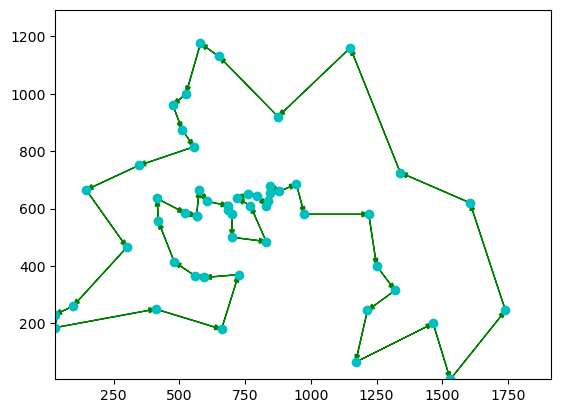

In [3]:
# Define th problem parameters
cities = berlin52_tsp.cities
tsp_dist=berlin52_tsp.eval_distances_from_cities(cities)
tsp_dist_int=list(np.array(tsp_dist).astype(int))

# Define the data model
def create_data_model():
    data = {}
    data['distance_matrix'] = tsp_dist_int
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

# Calculate the distance matrix
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

# Print the solution
def print_solution(manager, routing, solution):
    print('Objective: {} meters'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}meters\n'.format(route_distance)

# Create the model
data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)      

routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH) # GREEDY_DESCENT, SIMULATED_ANNEALING, TABU_SEARCH, GENERIC_TABU_SEARCH
search_parameters.time_limit.seconds = 30
search_parameters.log_search = True

# Find the solution
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print_solution(manager, routing, solution)

def get_routes(solution, routing, manager):
  routes = []
  for route_nbr in range(routing.vehicles()):
    index = routing.Start(route_nbr)
    route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
      index = solution.Value(routing.NextVar(index))
      route.append(manager.IndexToNode(index))
    routes.append(route)
  return routes

routes = get_routes(solution, routing, manager)

# Print the route
for i, route in enumerate(routes):
  print('Route', i, route)

# Visualize the route
berlin52_tsp.plot(route)

## Solving TSP using Tabu Search (TS)

Tabu search is initialized:
current value = 31222.196907873895
Tabu search is initialized:
current value = 34046.539488267445
Tabu search is done: 
curr iter: 100, curr best value: 8285.412862107858, curr best: sol: [0, 31, 48, 35, 36, 47, 23, 37, 39, 38, 34, 33, 43, 45, 24, 11, 50, 10, 51, 13, 12, 46, 25, 26, 27, 3, 5, 4, 14, 42, 32, 9, 8, 7, 40, 18, 44, 2, 16, 6, 1, 41, 20, 22, 19, 49, 15, 28, 29, 30, 17, 21, 0], found at iter: 42
[0, 31, 48, 35, 36, 47, 23, 37, 39, 38, 34, 33, 43, 45, 24, 11, 50, 10, 51, 13, 12, 46, 25, 26, 27, 3, 5, 4, 14, 42, 32, 9, 8, 7, 40, 18, 44, 2, 16, 6, 1, 41, 20, 22, 19, 49, 15, 28, 29, 30, 17, 21, 0]


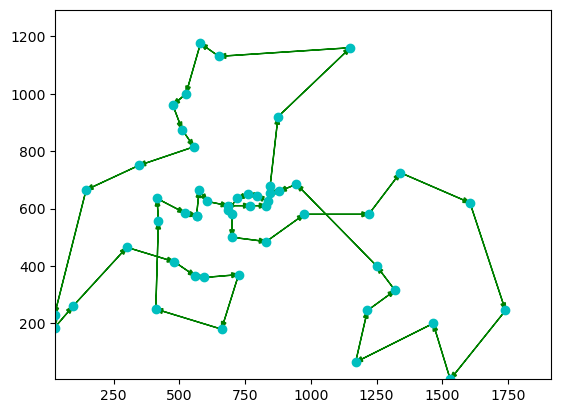

8285.412862107858


In [4]:
# Create an TS object to help solving the tsp problem
ts = TabuSearch(max_iter=100, tabu_tenure=5, neighbor_size=10000, use_aspiration=True, aspiration_limit=2, use_longterm=False, debug=1)

# Get an initial random solution and check its length 
ts.init_ts(berlin52_tsp,'random')
ts.val_cur

# Run TS and eval the best solution distance
ts.run(berlin52_tsp, repetition=1)
ts.val_allbest

# Print the best route
print(ts.s_best)

# Visualize the best route
berlin52_tsp.plot(ts.s_best)

# Print the route length
print(ts.val_best)